# Big mart sales is a knowledge competition by Analytics Vidhya

[Link](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/) to the competition

## Data available:
Sales data and other attributes of 1559 products across 10 stores of BigMart in the year 2013.

## Problem Statement
The aim is to build a predictive model to find out sales for each product at a particular store

## Evaluation Metric
Root Mean Squared Error ([RMSE](https://www.kaggle.com/wiki/RootMeanSquaredError))

In [1]:
# Importing required libraries
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import mode
from scipy.stats import norm
from sklearn import preprocessing

/usr/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# Reading train and test data
# Please change the folder path to read in the data.

train = pd.read_csv('../input/Train_UWu5bXk.csv')
test = pd.read_csv('../input/Test_u94Q5KV.csv')

## Data preprocessing and visualization

In [3]:
# Concatenate train and test data for cleaning

test['Item_Outlet_Sales'] = np.nan
train['source'] = 'Train'
test['source'] = 'Test'
total = pd.concat([train, test])

In [4]:
# Check the length of unique values for each variable in the dataset

total.apply(lambda x: len(pd.unique(x)))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

In [5]:
total.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
source                        object
dtype: object

As we can see that there are 1559 products (Item_Identifier) and 10 stores (Outlet_Identifier)

Let's treat each variable separately, as there are only handful of attributes

In [6]:
total.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,Train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Train


In [7]:
# Missing values

total.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

Only two variables have missing values. Ignoring Item_Outlet_Sales as we have introduced NaN for test data.

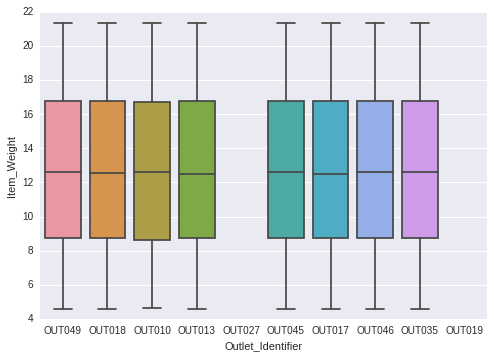

In [8]:
sns.boxplot(total['Outlet_Identifier'], total['Item_Weight'])

Two outlets does not have the Item_Weight information

In [9]:
# Item_Weight

# We can fill missing values in Item_Weight, by taking the average weight of products for each Item_Identifier

item_avg_weight = total.pivot_table(values='Item_Weight', index='Item_Identifier')
missing_index = total['Item_Weight'].isnull()
total.loc[missing_index,'Item_Weight'] = total.loc[missing_index,'Item_Identifier'].apply(lambda x: item_avg_weight[x])

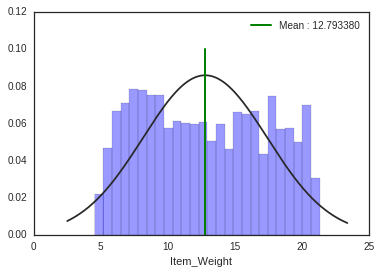

In [10]:
sns.set_style("white")
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
ax = sns.distplot(total['Item_Weight'], kde=False, fit=norm, color='b')
ax.plot([np.mean(total['Item_Weight']),np.mean(total['Item_Weight'])],[0,0.1], lw=2, color='g', label='Mean : {:5F}'.format(np.mean(total['Item_Weight'])))
ax.legend()

Number of values with zero weight: 0


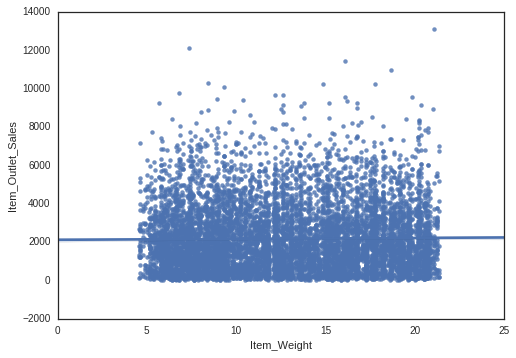

In [11]:
ax = sns.regplot(total.loc[total.source == 'Train',:]['Item_Weight'],total.loc[total.source == 'Train',:]['Item_Outlet_Sales']) 
print 'Number of values with zero weight: {}'.format(sum(total['Item_Weight'] == 0))

Even though, we have processed Item_Weight variable, there seems to be no relationship against the target variable. This variable may not be useful to statistical models. Let's keep it for now.

In [12]:
# Item_Fat_Content
total.Item_Fat_Content.value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

There seems to be an error in the levels of Item_Fat_Content

In [13]:
total['Item_Fat_Content'] = total['Item_Fat_Content'].replace({'LF': 'Low Fat',
                                                               'reg': 'Regular',
                                                               'low fat': 'Low Fat'})
total.Item_Fat_Content.value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

Double check with the Item_Type

In [14]:
total.pivot_table(values='Item_Fat_Content', columns='Item_Type', aggfunc=(lambda x: set([i for i in x])))

Item_Type
Baking Goods             {Low Fat, Regular}
Breads                   {Low Fat, Regular}
Breakfast                {Low Fat, Regular}
Canned                   {Low Fat, Regular}
Dairy                    {Low Fat, Regular}
Frozen Foods             {Low Fat, Regular}
Fruits and Vegetables    {Low Fat, Regular}
Hard Drinks                       {Low Fat}
Health and Hygiene                {Low Fat}
Household                         {Low Fat}
Meat                     {Low Fat, Regular}
Others                            {Low Fat}
Seafood                  {Low Fat, Regular}
Snack Foods              {Low Fat, Regular}
Soft Drinks              {Low Fat, Regular}
Starchy Foods            {Low Fat, Regular}
Name: Item_Fat_Content, dtype: object

Certainly, levels of Item_Type like 'Household', 'Health and Hygiene' cannot have fat content. Also, the level others is ambiguous.
So, assign another level of fat content to these item types.

In [15]:
total.loc[total.Item_Type == 'Household', 'Item_Fat_Content'] = 'No Fat'
total.loc[total.Item_Type == 'Health and Hygiene', 'Item_Fat_Content'] = 'No Fat'
total.loc[total.Item_Type == 'Others', 'Item_Fat_Content'] = 'No Fat'
# There could be a better way to do this.
total.Item_Fat_Content.value_counts()

Low Fat    6499
Regular    5019
No Fat     2686
Name: Item_Fat_Content, dtype: int64

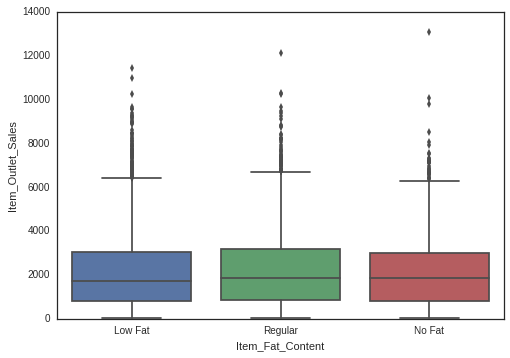

In [16]:
sns.boxplot(x=total.loc[total.source=='Train',:]['Item_Fat_Content'], y=total.loc[total.source=='Train',:]['Item_Outlet_Sales'])

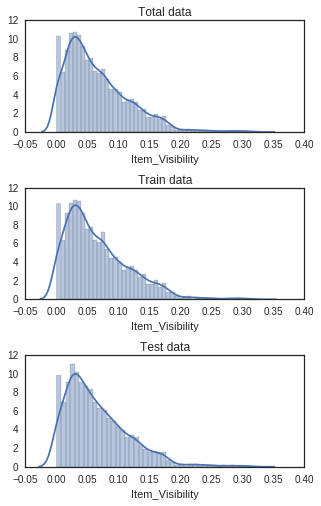

In [17]:
# Item_Visibility
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(5, 8)
fig.subplots_adjust(hspace=.5)
sns.distplot(total['Item_Visibility'], ax=ax1)
ax1.set_title("Total data")
sns.distplot(total[total.source == 'Train']['Item_Visibility'], ax=ax2)
ax2.set_title("Train data")
sns.distplot(total[total.source == 'Test']['Item_Visibility'], ax=ax3)
ax3.set_title("Test data")

The distribution of Item_Visibility looks similar for both train and test datasets. There seems to be items with zero visibility.

In [18]:
# Fill zero visibility with the mean of visibility according to Item_Identifier
item_avg_visibility = total.pivot_table(values='Item_Visibility', index='Item_Identifier')
missing_index = total['Item_Visibility'] == 0
total.loc[missing_index,'Item_Visibility'] = total.loc[missing_index,'Item_Identifier'].apply(lambda x: item_avg_visibility[x])

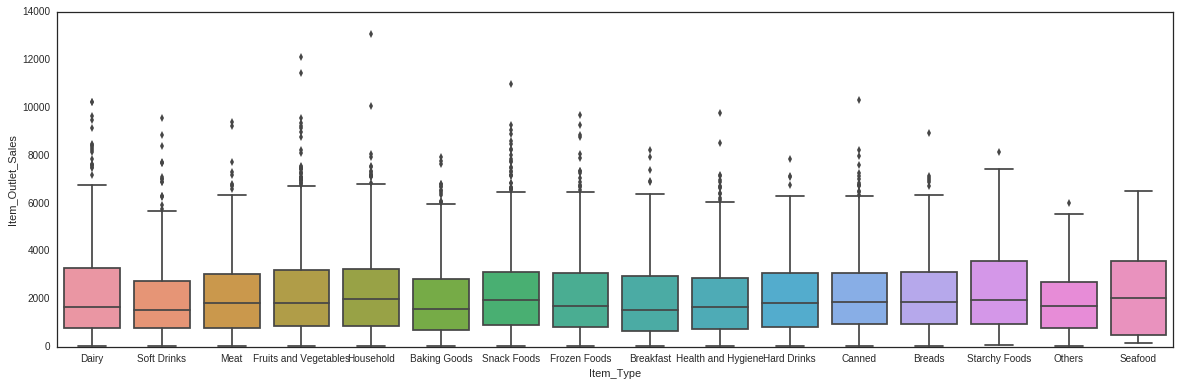

In [19]:
# Item_Type
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
sns.boxplot(total[total.source=='Train']['Item_Type'], total[total.source=='Train']['Item_Outlet_Sales'])

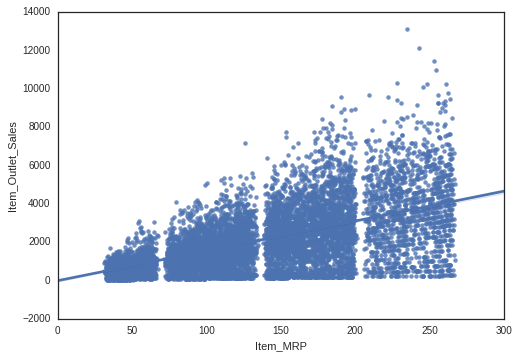

In [20]:
# Item_MRP
ax = sns.regplot(total[total.source == 'Train']['Item_MRP'], total[total.source == 'Train']['Item_Outlet_Sales'])

Interesting! There is a clear distinction of Sales with MRP of the item

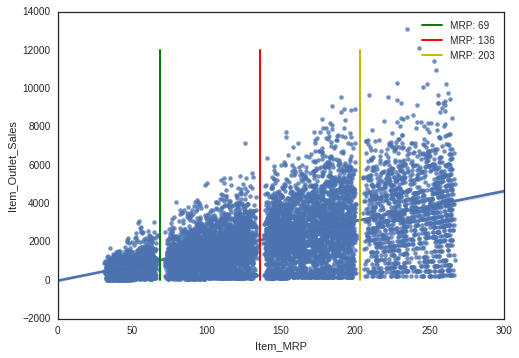

In [21]:
ax = sns.regplot(total[total.source == 'Train']['Item_MRP'], total[total.source == 'Train']['Item_Outlet_Sales'])
ax.plot([69,69],[0,12000], lw=2, color='g', label='MRP: 69')
ax.plot([136,136],[0,12000], lw=2, color='r', label='MRP: 136')
ax.plot([203,203],[0,12000], lw=2, color='y', label='MRP: 203')
ax.legend()

In [22]:
# Feature engineering
# Feature 1

total['MRP_Level'] = 'None'
total.loc[total.Item_MRP < 69, 'MRP_Level'] = 'Low'
total.loc[(total.Item_MRP >= 69) & (total.Item_MRP < 136), 'MRP_Level'] = 'Medium'
total.loc[(total.Item_MRP >= 136) & (total.Item_MRP < 203), 'MRP_Level'] = 'High'
total.loc[total.Item_MRP > 203, 'MRP_Level'] = 'Very High'

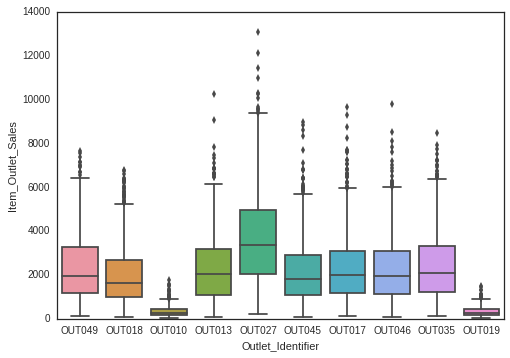

In [23]:
sns.boxplot(x=total.loc[total.source=='Train',:]['Outlet_Identifier'], y=total.loc[total.source=='Train',:]['Item_Outlet_Sales'])

Outlets 10 and 19 seems to have less sales than the rest of the outlets.

In [24]:
# Outlet_Establishment_Year

# As the data provided is for 2013, we can calculate the functional age of each outlet
# Feature 2
total['Outlet_age'] = 2013 - total.loc[:,'Outlet_Establishment_Year']
total = total.drop('Outlet_Establishment_Year', axis=1)

In [25]:
# Outlet_Size
# This variable had missing values
print 'Number of missing values: {}'.format(total['Outlet_Size'].isnull().sum())

Number of missing values: 4016


In [26]:
total.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: set([i for i in x])))

Outlet_Type
Grocery Store                      {nan, Small}
Supermarket Type1    {High, nan, Medium, Small}
Supermarket Type2                      {Medium}
Supermarket Type3                      {Medium}
Name: Outlet_Size, dtype: object

From the box plot of Outlet_Identifier above, Grocery Store have small outlet sizes and less sales as such.

In [27]:
total.loc[total.Outlet_Type == 'Supermarket Type1', 'Outlet_Size'].value_counts()

Small     3100
High      1553
Medium    1550
Name: Outlet_Size, dtype: int64

Major portion of 'Supermarket Type1' have small outlet size. We observe missing values only in these outlet types. Hence, replacing all the missing values with 'Small'

In [28]:
total['Outlet_Size'] = total['Outlet_Size'].fillna('Small')

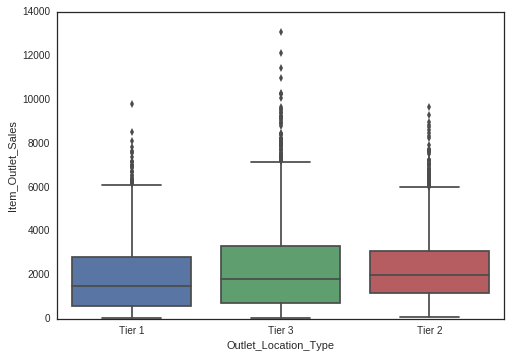

In [29]:
sns.boxplot(x=total.loc[total.source=='Train',:]['Outlet_Location_Type'], y=total.loc[total.source=='Train',:]['Item_Outlet_Sales'])

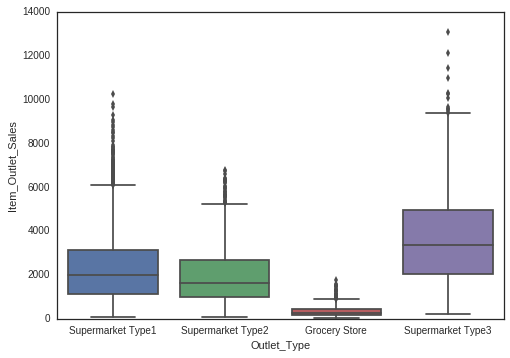

In [30]:
sns.boxplot(x=total.loc[total.source=='Train',:]['Outlet_Type'], y=total.loc[total.source=='Train',:]['Item_Outlet_Sales'])

As expected, Grocery type outlets have less sales.

In [31]:
total.isnull().sum()

Item_Identifier            0
Item_Weight                0
Item_Fat_Content           0
Item_Visibility            0
Item_Type                  0
Item_MRP                   0
Outlet_Identifier          0
Outlet_Size                0
Outlet_Location_Type       0
Outlet_Type                0
Item_Outlet_Sales       5681
source                     0
MRP_Level                  0
Outlet_age                 0
dtype: int64

## Now that we have filled all the missing values. Time to focus on feature engineering.

In [32]:
# Feature 3
total['Item_Rating'] = np.log1p(total['Item_MRP']/total['Item_Visibility'])

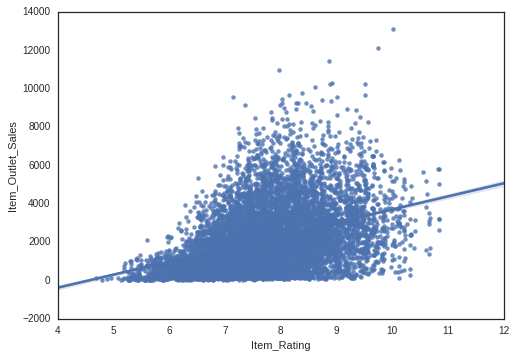

In [33]:
sns.regplot(total[total.source == 'Train']['Item_Rating'], total[total.source == 'Train']['Item_Outlet_Sales'])

We can clearly see that the new feature Item_Rating is correlated with the target variable.

In [34]:
# Feature 3
total['Item_Type_Combined'] = total['Item_Identifier'].apply(lambda x: x[0:2])
total['Item_Type_Combined'] = total['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})

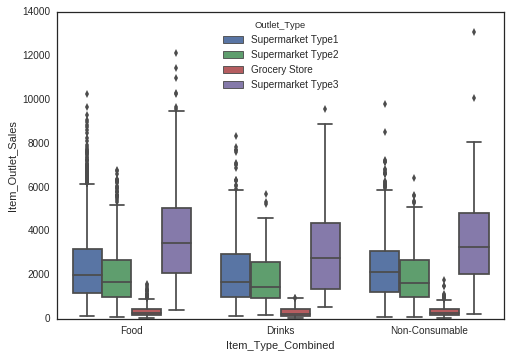

In [35]:
sns.boxplot(total[total.source == 'Train']['Item_Type_Combined'], total[total.source == 'Train']['Item_Outlet_Sales'], hue=total[total.source == 'Train']['Outlet_Type'])

In [36]:
# Feature 4
total['Item_Outlet_Category'] = total.loc[:,'Item_Type_Combined'].astype(str)+total.loc[:,'Outlet_Type'].astype(str)

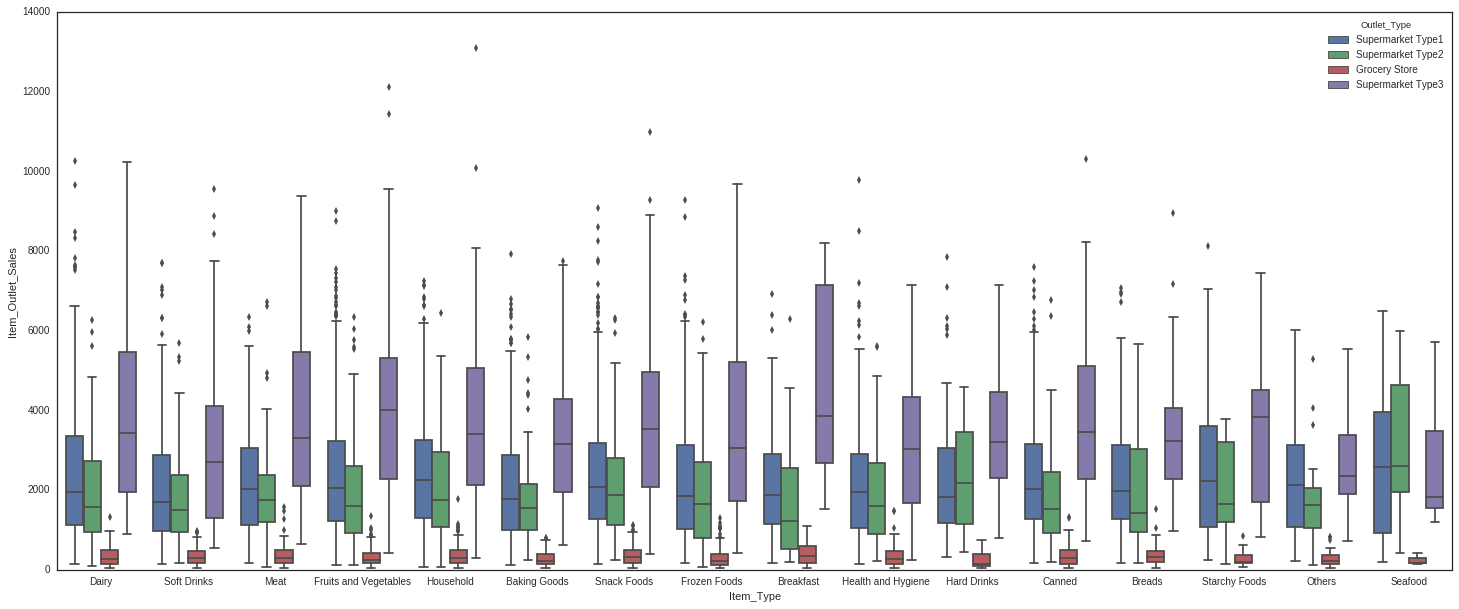

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
sns.boxplot(total[total.source == 'Train']['Item_Type'], total[total.source == 'Train']['Item_Outlet_Sales'], hue=total[total.source == 'Train']['Outlet_Type'])

Item_Outlet_Sales and Item_MRP are strongly correlated from the regression plot(see above) and it is much more evident from the above plot that it is also dependent on Outlet_Type.

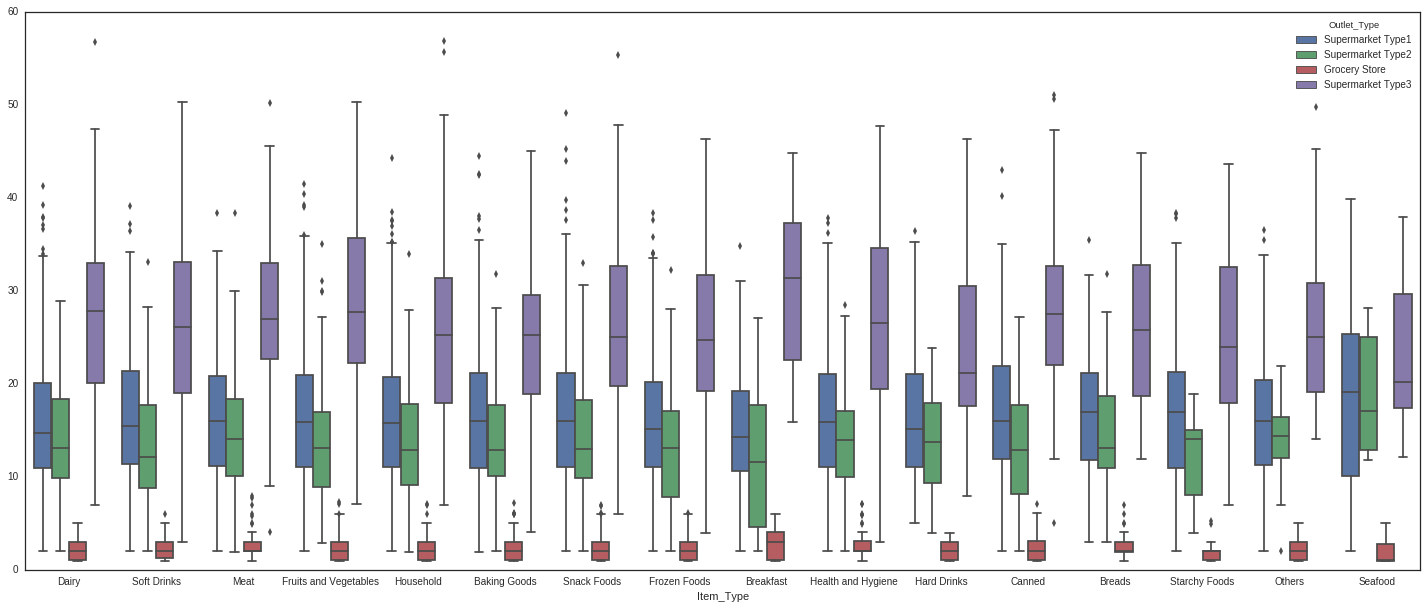

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
sns.boxplot(total[total.source == 'Train']['Item_Type'], total[total.source == 'Train']['Item_Outlet_Sales']/total[total.source == 'Train']['Item_MRP'], hue=total[total.source == 'Train']['Outlet_Type'])

Now, the separation is much more clearer. Hence, we divide Sales by MRP to scale the target variable.

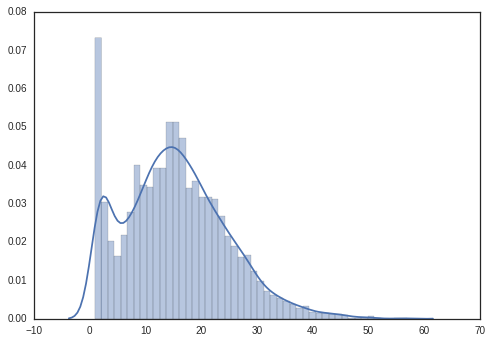

In [39]:
sns.distplot(total[total.source == 'Train']['Item_Outlet_Sales']/total[total.source == 'Train']['Item_MRP'])

Plot looks near to Normal distribution.

In [40]:
train1 = total.loc[total.source == 'Train']
test1 = total.loc[total.source == 'Test']

In [41]:
train1.loc[:, 'Item_Outlet_Sales'] = np.array(train1['Item_Outlet_Sales'])/np.array(train1['Item_MRP'])
train1 = train1.drop(['source', 'Item_Identifier', 'Item_Type'], axis=1)
test1 = test1.drop(['source', 'Item_Outlet_Sales', 'Item_Identifier', 'Item_Type'], axis=1)

/usr/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### After predictions, we should not forget to multiply the predictions with the MRP of the test data.

In [42]:
print train1.shape
print test1.shape

(8523, 14)
(5681, 13)


In [43]:
train1.to_csv('../input/train_processed.csv', index=False)
test1.to_csv('../input/test_processed.csv', index=False)